In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

import tensorflow as tf
from tensorflow.data import experimental
from matplotlib import gridspec
%matplotlib inline

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Aug  4 05:21:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [4]:
#run every session
#takes about 3 mins to run
drive.mount('/content/drive')
shared_folder_path = '/content/drive/MyDrive/DATASCI 207 Project/data'
file_path = os.path.join(shared_folder_path, 'LSWMD.pkl')
print(file_path)
df = pd.read_pickle(file_path)

Mounted at /content/drive
/content/drive/MyDrive/DATASCI 207 Project/data/LSWMD.pkl


In [5]:
#Renaming a column with a typo
df.rename(columns = {'trianTestLabel':'trainTestLabel'}, inplace = True)

#Function to extract string from a list or ndarray
def extract_string(x):
    if isinstance(x, list) and len(x) > 0:
        return x[0]
    elif isinstance(x, np.ndarray) and x.size > 0:
        return x.item(0)
    return x

#Applying the function to the dataframe
df['failureType'] = df['failureType'].apply(extract_string)
df['trainTestLabel'] = df['trainTestLabel'].apply(extract_string)

#Converting columns to string type
df['failureType'] = df['failureType'].astype(str)
df['trainTestLabel'] = df['trainTestLabel'].astype(str)

In [6]:
df.head()

df.shape

(811457, 6)

In [7]:
# Show the value counts for the 'failureType' column
df['failureType'].value_counts()

# Remove rows where 'failureType' is '[]' (unknown label)
df_clean_0 = df[df["failureType"]!="[]"]

df_clean_0 = df_clean_0[~df_clean_0["failureType"].isin(["Scratch","Random","Donut",'Near-full'])] #take out "Scratch","Random","Donut",'Near-full' for low sample sizes

df_clean_0['failureType'].value_counts()

,count
failureType,
none,147431
Edge-Ring,9680
Edge-Loc,5189
Center,4294
Loc,3593


In [8]:
147431+9680+5189+4294+3593

170187

In [9]:
# Function to get dimensions of the wafer map
def get_dim(x):
    dim0 = np.size(x, axis=0)
    dim1 = np.size(x, axis=1)
    return dim0, dim1

In [10]:
# Apply the function to get dimensions of each wafer map
df_clean_0['waferMapDim']= df_clean_0['waferMap'].apply(lambda x: get_dim(x))

# Show the value counts for the dimensions of the wafer maps
df_clean_0["waferMapDim"].value_counts().sort_values(ascending = False) #resize all to 50X50

,count
waferMapDim,
"(25, 27)",18684
"(26, 26)",14203
"(30, 34)",12304
"(29, 26)",11660
"(27, 25)",10648
"(39, 37)",10041
"(33, 29)",8036
"(42, 44)",6683
"(44, 41)",6060


                                            waferMap  dieSize lotName  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   

   waferIndex trainTestLabel failureType waferMapDim  
0         1.0       Training        none    (45, 48)  
1         2.0       Training        none    (45, 48)  
2         3.0       Training        none    (45, 48)  
3         4.0       Training        none    (45, 48)  
4         5.0       Training        none    (45, 48)  


<Axes: title={'center': 'Distribution of Failure Types'}, xlabel='failureType', ylabel='Frequency'>

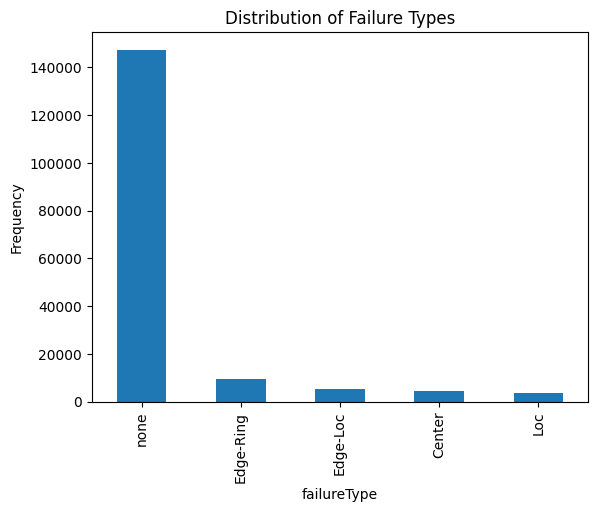

In [11]:
print(df_clean_0.head())
df_clean_0['failureType'].value_counts().sort_values(ascending = False).plot(kind='bar', title='Distribution of Failure Types', ylabel='Frequency')

In [12]:
# Function to resize wafer maps to 50x50 pixels
def resize_wafer_map(wafer_map):
    wafer_map_np = np.array(wafer_map)
    resized_wafer_map = cv2.resize(wafer_map_np, (50, 50), interpolation=cv2.INTER_NEAREST)
    return resized_wafer_map

In [13]:
# Apply the function to resize wafer maps
df_clean_0['resizedWaferMap'] = df_clean_0['waferMap'].apply(resize_wafer_map)

In [14]:
# Function to plot original and resized images
def plot_images(df, num_samples):
    samples = df.sample(n=num_samples, random_state=42)
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 2))

    for i, (idx, row) in enumerate(samples.iterrows()):
        original = np.array(row['waferMap'])
        resized = np.array(row['resizedWaferMap'])

        original_shape = original.shape

        axes[i, 0].imshow(original, cmap='gray')
        axes[i, 0].set_title(f'Original ({original_shape[0]}x{original_shape[1]})')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(resized, cmap='gray')
        axes[i, 1].set_title('Resized (50x50)')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

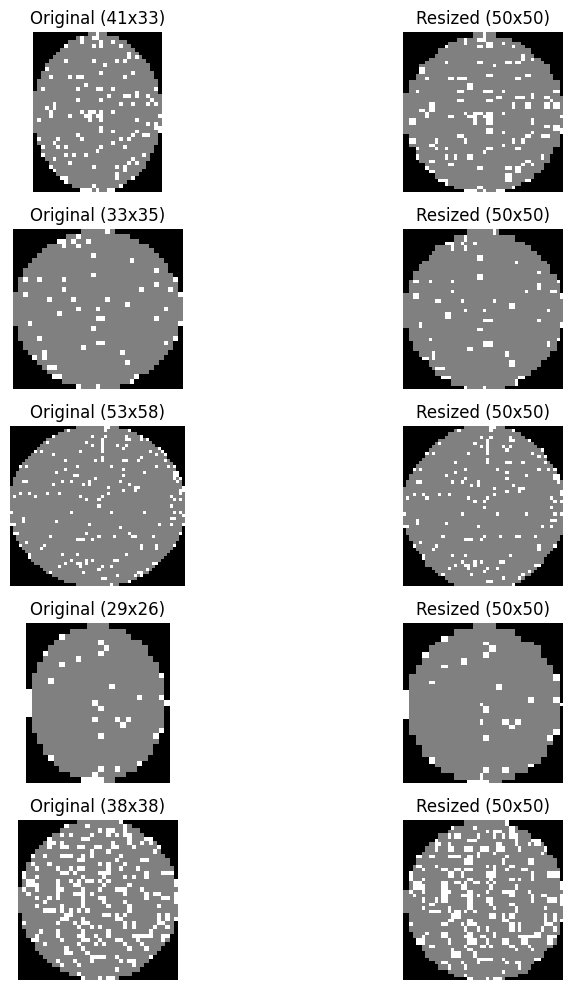

In [15]:
plot_images(df_clean_0, num_samples=5)


In [16]:
df_clean_0['resizeWaferMapDim']= df_clean_0['resizedWaferMap'].apply(lambda x: get_dim(x))

df_clean_0['resizeWaferMapDim'].value_counts()

,count
resizeWaferMapDim,
"(50, 50)",170187


In [17]:
# Calculate the proportion of the majority class 'none'. This would be the wafer with no issues
df_clean_0['failureType'].value_counts()[0]/df_clean_0['failureType'].value_counts().sum() #majority class "none" is 87% of data

<ipython-input-17-287f5d7ac576>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_clean_0['failureType'].value_counts()[0]/df_clean_0['failureType'].value_counts().sum() #majority class "none" is 87% of data


0.8662882593852644

In [18]:
# Show the value counts for 'failureType' column after cleaning
df_clean_0["failureType"].value_counts()

,count
failureType,
none,147431
Edge-Ring,9680
Edge-Loc,5189
Center,4294
Loc,3593


In [19]:
# Encode 'failureType' labels as integers for modeling
label_mapping = {
    'Center': 1,
    'Edge-Loc': 2,
    'Edge-Ring': 3,
    'Loc': 4,
    'none': 0
}

df_clean_0['encodedFailureType'] = df_clean_0['failureType'].replace(label_mapping) #encode label for CNN model

In [20]:
# Function to reshape data to the required format for modeling
def reshape_data(data):
  reshaped_images = []
  for i in range(len(data)):
    reshaped_image = np.reshape(data[i], (50, 50))
    reshaped_images.append(reshaped_image)

  data = np.array(reshaped_images)
  data = data.reshape(-1, 50, 50, 1)
  return data

In [21]:

from sklearn.preprocessing import StandardScaler


tf.random.set_seed(1234)
np.random.seed(1234)

# Prepare features (X) and labels (Y)
X = df_clean_0['resizedWaferMap']
Y = df_clean_0['encodedFailureType']

# shuffle data
indx = np.arange(len(X))
np.random.shuffle(indx)
X = np.array(X)[indx]
Y= np.array(Y)[indx]

X_train, X_other, y_train, y_other = train_test_split(X, Y, test_size=0.4, random_state=1234)

X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size=0.5, random_state=1234)

X_train = reshape_data(X_train)
X_val = reshape_data(X_val)
X_test = reshape_data(X_test)

#############
#############
#Adding Scaler
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train.reshape(-1, 50*50*1)).reshape(-1, 50, 50, 1)
X_val_flat = scaler.transform(X_val.reshape(-1, 50*50*1)).reshape(-1, 50, 50, 1)
X_test_flat = scaler.transform(X_test.reshape(-1, 50*50*1)).reshape(-1, 50, 50, 1)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (102112, 50, 50, 1)
y_train shape (102112,)
X_val shape (34037, 50, 50, 1)
y_val shape (34037,)
X_test shape (34038, 50, 50, 1)
y_test shape (34038,)


In [22]:
# Baseline model: predict the majority class for all inputs
majority_class = 0
y_train_pred = [majority_class] * len(y_train)
y_val_pred = [majority_class] * len(y_val)

# Calculate accuracy for the baseline model
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)


print("Baseline Model")
print("Train Accuracy: {:.2f}%".format(train_accuracy * 100))
print("Validation Accuracy: {:.2f}%".format(val_accuracy * 100))

Baseline Model
Train Accuracy: 86.59%
Validation Accuracy: 86.78%


In [23]:
# Print the shape of one image and the total number of images
example_image_shape = X_train[0].shape
print("Shape of one image:", example_image_shape)
print("Number of Images:",X_train.shape)

Shape of one image: (50, 50, 1)
Number of Images: (102112, 50, 50, 1)


In [24]:
# Print the class distribution in the training set
unique, frequency = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, frequency))
print("Class Distribution:", class_distribution)

Class Distribution: {0: 88417, 1: 2584, 2: 3146, 3: 5789, 4: 2176}


first undersampled the majority class "none" to 6000, and then augmented the other classes till they has 6000 images I used 6000 because 5789 (class 4) was the most frequent class after the majority "none" class

All done below

In [25]:
# Downsample the majority class 'none' (class 0) to 6000 instances
class_0_indices = np.where(y_train == 0)[0]
undersample_0_indices = np.random.choice(class_0_indices, 6000, replace=False)

# Retain indices of other classes
other_class_indices = np.where(y_train != 0)[0]

# Combine undersampled class 0 with all other classes
new_indices = np.concatenate([undersample_0_indices, other_class_indices])
X_train_undersampled = X_train[new_indices]
y_train_undersampled = y_train[new_indices]

# Initialize lists to store augmented data and labels
X_train_augmented = []
y_train_augmented = []

# Set up the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to augment data for a specific class
def augment_class(X_class, y_class, target_count=6000):
    X_augmented = []
    y_augmented = []
    current_count = len(X_class)

    while current_count < target_count:
        # Number of samples to generate in this batch
        augment_count = min(target_count - current_count, len(X_class))

        # Generate augmented images
        X_aug_batch = next(datagen.flow(X_class, batch_size=augment_count, shuffle=False))

        X_augmented.extend(X_aug_batch)
        y_augmented.extend([y_class[0]] * augment_count)

        current_count += augment_count

    return np.array(X_augmented), np.array(y_augmented)

# Augment data for classes 1, 2, 3, and 4
classes = [1, 2, 3, 4]


#########
#########
#Modified, X_train_flat
for cls in classes:
    X_class = X_train_flat[y_train == cls]
    y_class = y_train[y_train == cls]

    X_aug, y_aug = augment_class(X_class, y_class, target_count=6000)
    X_train_augmented.extend(X_aug)
    y_train_augmented.extend(y_aug)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

# Combine undersampled data with augmented data
X_train_final = np.concatenate([X_train_undersampled, X_train_augmented])
y_train_final = np.concatenate([y_train_undersampled, y_train_augmented])



In [26]:

# Print the final class distribution after augmentation
final_class_distribution = dict(zip(*np.unique(y_train_final, return_counts=True)))
print("Final class distribution:", final_class_distribution)

Final class distribution: {0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000}


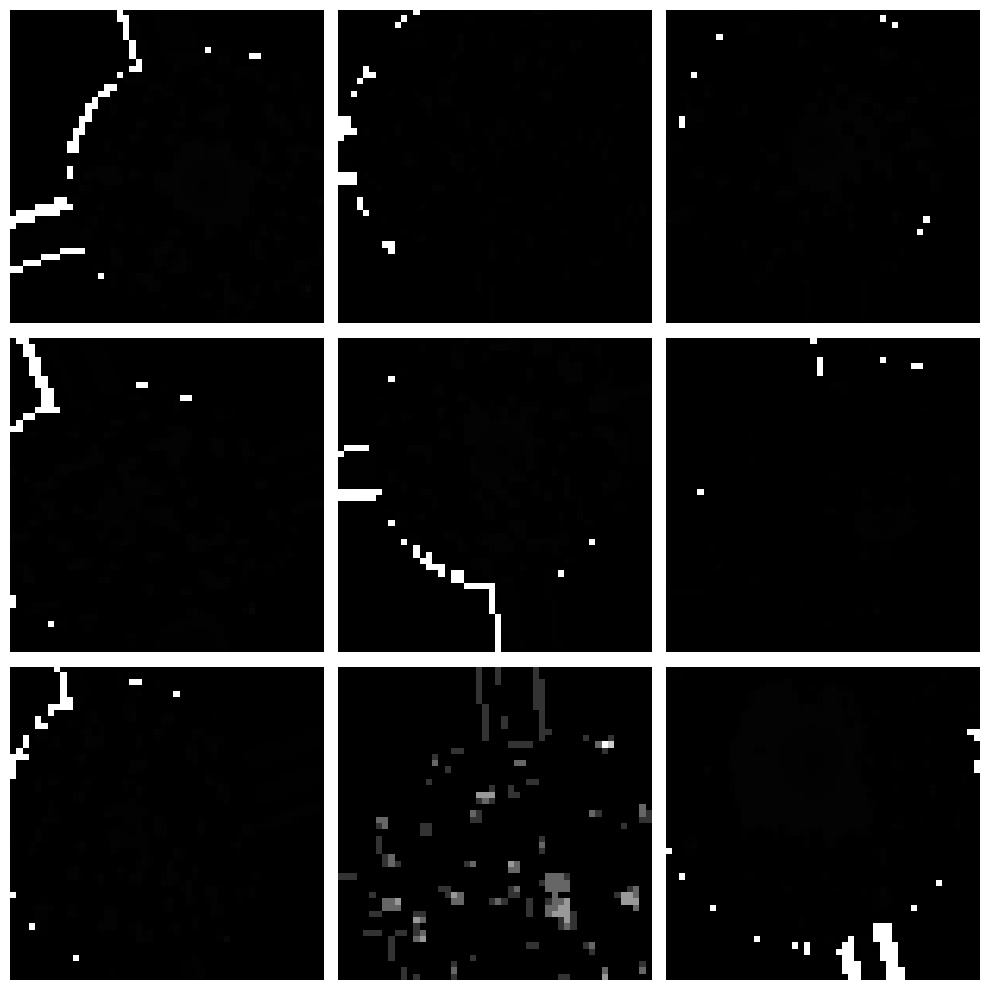

In [27]:
def plot_images(images, num_images=9):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype('uint8'),cmap='gray')
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Visualize augmented images
plot_images(X_train_augmented)

In [28]:
# Normalize the final training, validation, and test datasets
X_train_final = X_train_final / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [29]:
y_train_final.shape

(30000,)

In [30]:
X_train_final.shape

(30000, 50, 50, 1)

In [ ]:
X_train_path = os.path.join(shared_folder_path, 'X_train.npy')
y_train_path = os.path.join(shared_folder_path, 'y_train.npy')
X_val_path = os.path.join(shared_folder_path, 'X_val.npy')
y_val_path = os.path.join(shared_folder_path, 'y_val.npy')
X_test_path = os.path.join(shared_folder_path, 'X_test.npy')
y_test_path = os.path.join(shared_folder_path, 'y_test.npy')

# Save the datasets
np.save(X_train_path, X_train_final)
np.save(y_train_path, y_train_final)
np.save(X_val_path, X_val)
np.save(y_val_path, y_val)
np.save(X_test_path, X_test)
np.save(y_test_path, y_test)

# Confirm the files are saved
print(f"Files saved in {shared_folder_path}")